In [103]:
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from processing.preprocessing import BCIDataProcessor

recording_path_1 = '../recordings/recording_relax2.raw.fif'
recording_path_2 = '../recordings/recording_relax3.raw.fif'
rescale = True
window_size = 2
window_overlap = 0.33
filter_method = 'iir'
l_freq, h_freq = 10, 20

processor = BCIDataProcessor(recording_path_1, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
# Only select relax and focus
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[-2.75859755e-09,  6.58822355e-06,  1.19196667e-05, ...,
          -6.53445754e-06, -8.10259155e-06, -8.84459835e-06],
         [-1.05771001e-09, -3.81782756e-07, -7.76688674e-07, ...,
          -3.01867316e-06, -5.39087651e-06, -7.42446293e-06],
         [-2.85816626e-09,  1.36934219e-08,  4.52812403e-08, ...,
          -4.97722714e-06, -7.74024405e-06, -9.75942371e-06],
         ...,
         [-7.39293400e-10,  2.76738098e-06,  4.86841659e-06, ...,
          -1.33488083e-06, -2.17059583e-06, -2.78339685e-06],
         [-1.39442420e-09, -8.90089752e-08, -1.86083199e-07, ...,
          -3.46851677e-07, -1.29134428e-06, -2.16159753e-06],
         [-1.26045405e-09, -2.42412880e-06, -4.40465518e-06, ...,
           1.96653584e-06,  7.46746826e-07, -6.00096828e-07]],
 
        [[ 7.22537962e-06,  2.62723408e-06, -2.09849110e-06, ...,
           4.23855923e-06,  6.00172331e-06,  6.82361705e-06],
         [ 3.71442434e-06,  1.47105855e-06, -6.63788315e-07, ...,
          -5

In [104]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X.shape, y.shape

((48, 8, 500), (48,))

In [105]:
from sklearn.pipeline import Pipeline
from pyriemann.classification import TSClassifier

clf = Pipeline(steps=[('cov', Covariances(estimator='lwf')), ('ts', TSClassifier(metric='riemann'))])
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Training accuracy: {np.mean(y_pred == y)}")

Training accuracy: 0.9583333333333334


In [106]:
# Load the second recording and validate on that
processor = BCIDataProcessor(recording_path_2, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
# Only select relax/focus
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[-3.00207443e-10, -5.70210178e-06, -1.04791017e-05, ...,
           3.16270924e-06,  4.85458244e-06,  5.92251916e-06],
         [-6.52361091e-10, -9.84172183e-07, -1.86712781e-06, ...,
           5.21267974e-07,  2.39414498e-06,  3.87174178e-06],
         [-5.82325307e-10, -5.92767071e-07, -1.12299648e-06, ...,
           1.22569326e-06,  2.54620045e-06,  3.48927456e-06],
         ...,
         [-1.76256307e-09, -1.48573862e-06, -2.56163630e-06, ...,
           7.20887029e-06,  7.73060739e-06,  7.40922253e-06],
         [-1.15709216e-09, -1.13228087e-06, -2.04163925e-06, ...,
           1.30009994e-06,  2.24901922e-06,  2.90034921e-06],
         [-9.69460846e-11, -2.25287716e-06, -4.18742334e-06, ...,
           4.55470623e-06,  5.65412801e-06,  6.03537239e-06]],
 
        [[ 8.17646552e-06,  8.00788527e-06,  6.44657189e-06, ...,
           3.08425385e-06,  5.38125508e-06,  7.45286635e-06],
         [ 7.61118398e-06,  7.96037903e-06,  7.13830502e-06, ...,
          -1

In [107]:
# Prepare the data for validation
X_val = np.concatenate(list(data.values()), axis=0)
y_val = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)

# Evaluate the trained model on the validation data
val_score = clf.score(X_val, y_val)
print(f"Validation accuracy: {val_score}")

Validation accuracy: 0.8541666666666666


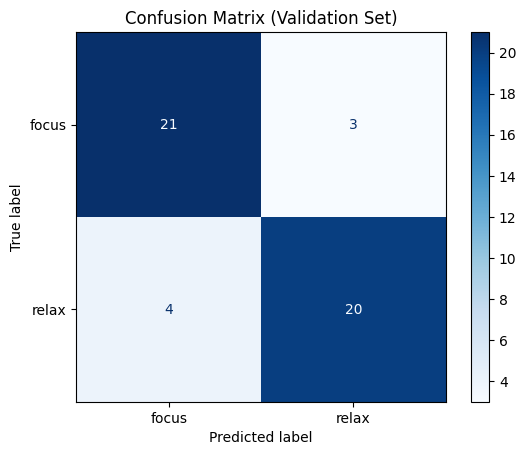

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the validation data
y_val_pred = clf.predict(X_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [109]:
# Load all the 2-second .npy files from recordings/focus_chunks and recordings/relax_chunks,
# filter them using the same filter and validate our model on them
import os
import mne
import numpy as np
from sklearn.metrics import accuracy_score

# Define paths to focus and relax chunks
focus_chunks_path = '../recordings/focus_chunks'
relax_chunks_path = '../recordings/relax_chunks'

# Load all .npy files
focus_chunks = [np.load(os.path.join(focus_chunks_path, f)) for f in os.listdir(focus_chunks_path) if f.endswith('.npy')]
relax_chunks = [np.load(os.path.join(relax_chunks_path, f)) for f in os.listdir(relax_chunks_path) if f.endswith('.npy')]

X_focus = []
X_relax = []
for fc in focus_chunks:
    # Assume data shape is (n_channels, n_times) = (8, 500)
    sfreq = 250  # Set your sampling frequency accordingly
    ch_names = ['Fz','C3','Cz','C4','Pz','PO7','Oz','PO8']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    raw = mne.io.RawArray(fc, info)

    # Bandpass filter (same as BCIDataProcessor)
    raw_filtered = raw.copy().filter(l_freq=10, h_freq=20, method='iir').notch_filter(freqs=[50])

    # Get the filtered data as numpy array, shape (n_channels, n_times)
    filtered_data = raw_filtered.get_data()
    X_focus.append(filtered_data)
for rc in relax_chunks:
    # Assume data shape is (n_channels, n_times) = (8, 500)
    sfreq = 250  # Set your sampling frequency accordingly
    ch_names = ['Fz','C3','Cz','C4','Pz','PO7','Oz','PO8']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    raw = mne.io.RawArray(rc, info).rescale(1e-6)

    # Bandpass filter (same as BCIDataProcessor)
    raw_filtered = raw.copy().filter(l_freq=10, h_freq=20, method='iir').notch_filter(freqs=[50])

    # Get the filtered data as numpy array, shape (n_channels, n_times)
    filtered_data = raw_filtered.get_data()
    X_relax.append(filtered_data)
X_focus = np.array(X_focus)  # Shape (n_samples, n_channels, n_times)
X_relax = np.array(X_relax)  # Shape (n_samples, n_channels, n_times)

# Combine and label the data
X = np.concatenate([X_focus, X_relax], axis=0)
y = np.array(['focus'] * len(X_focus) + ['relax'] * len(X_relax))

In [110]:
X.shape, y.shape, y

((51, 8, 500),
 (51,),
 array(['focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus',
        'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus',
        'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus',
        'focus', 'focus', 'focus', 'focus', 'focus', 'focus', 'focus',
        'focus', 'focus', 'relax', 'relax', 'relax', 'relax', 'relax',
        'relax', 'relax', 'relax', 'relax', 'relax', 'relax', 'relax',
        'relax', 'relax', 'relax', 'relax', 'relax', 'relax', 'relax',
        'relax', 'relax'], dtype='<U5'))

In [111]:
# Validate the model
y_pred = clf.predict(X)
val_accuracy = accuracy_score(y, y_pred)
print(f"Validation accuracy on .npy chunks: {val_accuracy}")

Validation accuracy on .npy chunks: 0.803921568627451


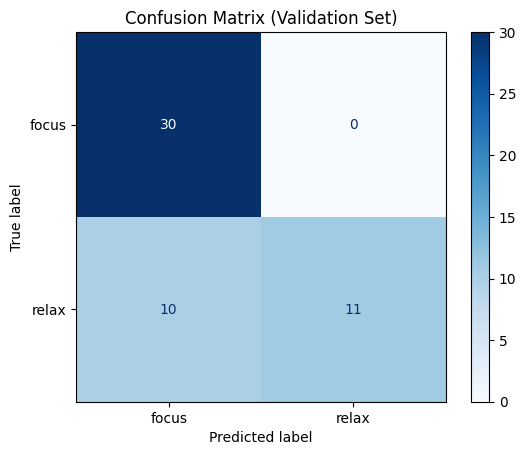

In [112]:
conf_matrix = confusion_matrix(y, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val_pred))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()